In [24]:
'''
Copyright (c) 2020
Author:
  Bruno Ferrarini (University of Essex)
This project is licensed under MIT.
'''

"""
    This tutorial shows how to design and train a simple Binary Neural Network with LARQ framework
    The experiments are:
        1) A regular full precision CNN is trained on MNIST
        2) As in 1) with the addition of BatchNormalization. BatchNorm is mandatory for BNN. This model is a comparison baseline for the BNN.
        3) The same CNN as in 1) is built using LARQ layers w/o binarization. This experiment is to show the equivalence between Keras ans LARQ layers.
        4) A Binary Network is trained on MNIST. The hyperparamenter used for the layers are the same as the above models
        5) Experiment 4 is repeated w/o batchNorm showing that BNN cannot be trained.
        6) Experiment 5 is repeated with bias.

    Experiments have some tuning parameters (e.g. training epochs) declared at the beginning of each section except the batch size that is declared before loading MINIST data.
"""

'\n    This tutorial shows how to design and train a simple Binary Neural Network with LARQ framework\n    The experiments are:\n        1) a regular full precision CNN is trained on MNIST\n        2) as in 1) with the addition of BatchNormalization. BatchNorm is mandatory for BNN, thus this model represents a comparison baseline for the BNN\n        3) The same CNN as in 1) is built using LARQ layers w/o binarization. This experiment is to show the equivalence between Keras ans LARQ layers.\n        4) A Binary Network is trained on MNIST. The hyperparamenter used for the layers are the same as the above models\n        5) The experiment 4 is repeated w/o batchNorm showing that BNN cannot be trained.\n        6) The experiment 5 is repeated with bias.\n\n'

In [25]:
import larq
import tensorflow as tf
# example of loading the MNIST dataset
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import numpy as np

In [57]:
"""
    Model Building Functions.
"""

def get_fp_model(input_shape, use_bn = False):
    input_image = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation=None)(input_image)
    if use_bn:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation=None)(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation=None)(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dense(10, activation='softmax')(x)
    model = Model(input_image, x)
    return model

def get_larq_fp(input_shape, use_bn = False):
    input_image = Input(shape=input_shape)
    x = larq.layers.QuantConv2D(32, (3, 3), activation=None)(input_image)
    if use_bn:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    x = larq.layers.QuantConv2D(64, (3, 3), activation=None)(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = larq.layers.QuantDense(64, activation=None)(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    x = larq.layers.QuantDense(10, activation='softmax')(x)
    model = Model(input_image, x)
    return model

def binary_model(input_shape, use_bn = False, use_bias=False):
    input_image = Input(shape=input_shape)
    x = input_image
    x = larq.layers.QuantConv2D(32, (3, 3), 
        kernel_quantizer='ste_sign', 
        input_quantizer=None, 
        kernel_constraint=larq.constraints.WeightClip(clip_value=1), 
        use_bias=use_bias )(x)
    x = MaxPooling2D((2, 2))(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = larq.layers.QuantConv2D(64, (3, 3), 
        kernel_quantizer='ste_sign', 
        input_quantizer='ste_sign', 
        kernel_constraint=larq.constraints.WeightClip(clip_value=1), 
        use_bias=use_bias)(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = larq.layers.QuantDense(64, 
        kernel_quantizer='ste_sign', 
        input_quantizer='ste_sign', 
        kernel_constraint=larq.constraints.WeightClip(clip_value=1), 
        use_bias=use_bias)(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = larq.layers.QuantDense(10, 
        kernel_quantizer='ste_sign', 
        input_quantizer='ste_sign', 
        kernel_constraint=larq.constraints.WeightClip(clip_value=1), 
        use_bias=use_bias,    
        activation='softmax')(x)
    model = Model(input_image, x)
    return model


In [27]:
"""
    This function loads MNIST data and reshapes the samples by adding the channel.
"""

def load_mnist(display=False):
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    print("TrainX {}".format(trainX.shape))
    print('TestX {}'.format(testX.shape))
    print('Train: X={}, y={}'.format(trainX.shape, trainY.shape))
    print('Test: X={}, y={}'.format(testX.shape, testY.shape))
    # expand dims to add the channel dimension
    trainX = np.expand_dims(trainX, axis=-1)
    testX = np.expand_dims(testX, axis=-1)
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY) 

    if display:
        for i in range(9):
            # define subplot
            pyplot.subplot(330 + 1 + i)
            # plot raw pixel data
            pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
            pyplot.xticks([])
            pyplot.yticks([])
        pyplot.show()

    return (trainX, trainY), (testX, testY)


In [28]:
# Comment this to enable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

TrainX (60000, 28, 28)
TestX (10000, 28, 28)
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


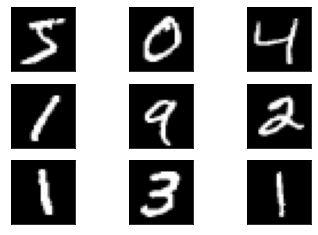

In [29]:
#  MNIST DATA ARE LOADED AND PRE-PROCESSED
batch_size = 64

mnist_train, mnist_test = load_mnist(display=True)
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_iterator = datagen.flow(mnist_train[0],  mnist_train[1], batch_size=batch_size)
test_iterator = datagen.flow(mnist_test[0], mnist_test[1], batch_size=batch_size)

input_shape = mnist_test[0][0].shape

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
re_lu_9 (ReLU)               (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
re_lu_10 (ReLU)              (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 64)        

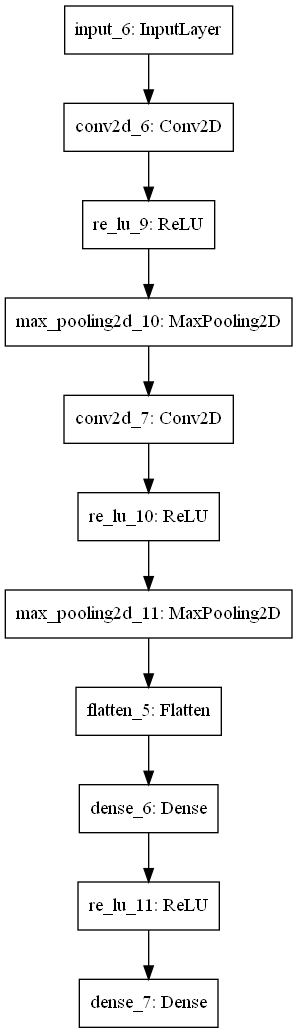

In [30]:
################
# EXPERIMENT 1 #
################

# Full Precision MODEL w/o Batch Norm
model1 = get_fp_model(input_shape, use_bn = False)
adam = tf.keras.optimizers.Adam(lr = 0.001)
model1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()
tf.keras.utils.plot_model(
    model1,
    to_file="plots/plots.exp1_model.png"
)

In [31]:
# FP MODEL on MNIST
history1 = model1.fit(train_iterator, validation_data = test_iterator, steps_per_epoch=len(train_iterator), epochs=10)

Epoch 1/10
938/938 [==============================] - 21s 22ms/step - loss: 0.1735 - accuracy: 0.9474 - val_loss: 0.0636 - val_accuracy: 0.9793
Epoch 2/10
938/938 [==============================] - 20s 21ms/step - loss: 0.0503 - accuracy: 0.9845 - val_loss: 0.0450 - val_accuracy: 0.9862
Epoch 3/10
938/938 [==============================] - 20s 21ms/step - loss: 0.0353 - accuracy: 0.9890 - val_loss: 0.0333 - val_accuracy: 0.9879
Epoch 4/10
938/938 [==============================] - 20s 22ms/step - loss: 0.0271 - accuracy: 0.9912 - val_loss: 0.0334 - val_accuracy: 0.9888
Epoch 5/10
938/938 [==============================] - 20s 21ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.0307 - val_accuracy: 0.9904
Epoch 6/10
938/938 [==============================] - 19s 20ms/step - loss: 0.0168 - accuracy: 0.9944 - val_loss: 0.0297 - val_accuracy: 0.9897
Epoch 7/10
938/938 [==============================] - 20s 21ms/step - loss: 0.0126 - accuracy: 0.9963 - val_loss: 0.0322 - val_accuracy:

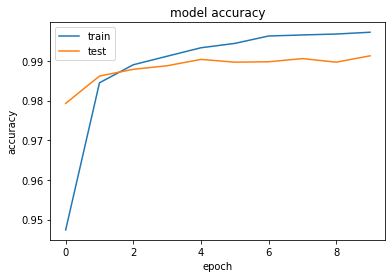

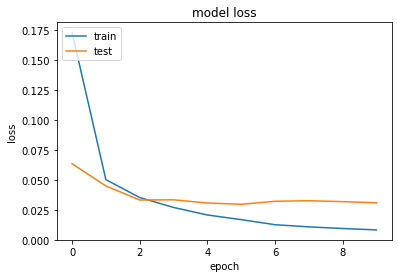

In [32]:
# summarize history1 for accuracy
pyplot.plot(history1.history['accuracy'])
pyplot.plot(history1.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history1 for loss
pyplot.plot(history1.history['loss'])
pyplot.plot(history1.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

In [33]:
################
# EXPERIMENT 2 #
################

# Full Precision MODEL with Batch Norm
model2 = get_fp_model(input_shape, use_bn = True)
adam = tf.keras.optimizers.Adam(lr = 0.001)
model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(train_iterator, validation_data = test_iterator, steps_per_epoch=len(train_iterator), epochs=10)

Epoch 1/10
938/938 [==============================] - 49s 52ms/step - loss: 0.1162 - accuracy: 0.9722 - val_loss: 0.0445 - val_accuracy: 0.9871
Epoch 2/10
938/938 [==============================] - 46s 50ms/step - loss: 0.0377 - accuracy: 0.9891 - val_loss: 0.0402 - val_accuracy: 0.9878
Epoch 3/10
938/938 [==============================] - 49s 52ms/step - loss: 0.0258 - accuracy: 0.9923 - val_loss: 0.0415 - val_accuracy: 0.9874
Epoch 4/10
938/938 [==============================] - 45s 47ms/step - loss: 0.0192 - accuracy: 0.9944 - val_loss: 0.0351 - val_accuracy: 0.9888
Epoch 5/10
938/938 [==============================] - 45s 48ms/step - loss: 0.0156 - accuracy: 0.9954 - val_loss: 0.0319 - val_accuracy: 0.9898
Epoch 6/10
938/938 [==============================] - 45s 48ms/step - loss: 0.0119 - accuracy: 0.9965 - val_loss: 0.0410 - val_accuracy: 0.9880
Epoch 7/10
938/938 [==============================] - 44s 47ms/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0284 - val_accuracy:

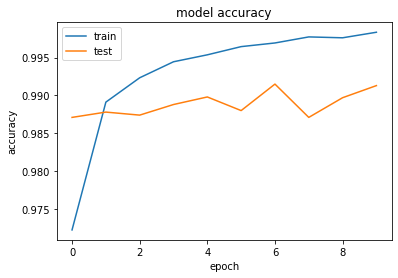

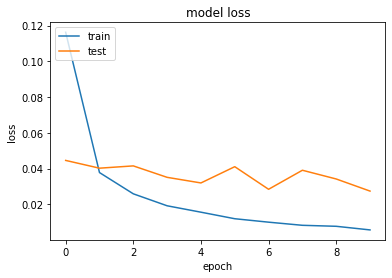

In [34]:
# summarize history for accuracy
pyplot.plot(history2.history['accuracy'])
pyplot.plot(history2.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history2.history['loss'])
pyplot.plot(history2.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

In [35]:
################
# EXPERIMENT 3 #
################

# LARQ FP MODEL with Batch Norm. The results should be similar to Experiment 2.
model3 = get_larq_fp(input_shape, use_bn = True) 
adam = tf.keras.optimizers.Adam(lr = 0.001)
model3.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history3 = model3.fit(train_iterator, validation_data = test_iterator, steps_per_epoch=len(train_iterator), epochs=10)

Epoch 1/10
938/938 [==============================] - 46s 49ms/step - loss: 0.1168 - accuracy: 0.9711 - val_loss: 0.0467 - val_accuracy: 0.9861
Epoch 2/10
938/938 [==============================] - 46s 49ms/step - loss: 0.0376 - accuracy: 0.9890 - val_loss: 0.0342 - val_accuracy: 0.9905
Epoch 3/10
938/938 [==============================] - 46s 49ms/step - loss: 0.0268 - accuracy: 0.9924 - val_loss: 0.0346 - val_accuracy: 0.9892
Epoch 4/10
938/938 [==============================] - 46s 49ms/step - loss: 0.0194 - accuracy: 0.9941 - val_loss: 0.0383 - val_accuracy: 0.9873
Epoch 5/10
938/938 [==============================] - 46s 49ms/step - loss: 0.0149 - accuracy: 0.9956 - val_loss: 0.0301 - val_accuracy: 0.9904
Epoch 6/10
938/938 [==============================] - 45s 48ms/step - loss: 0.0115 - accuracy: 0.9966 - val_loss: 0.0548 - val_accuracy: 0.9805
Epoch 7/10
938/938 [==============================] - 45s 48ms/step - loss: 0.0105 - accuracy: 0.9967 - val_loss: 0.0347 - val_accuracy:

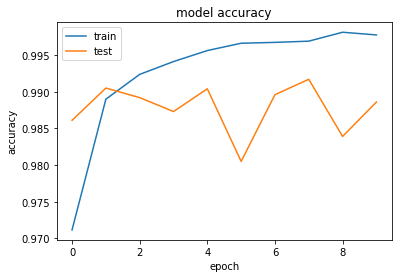

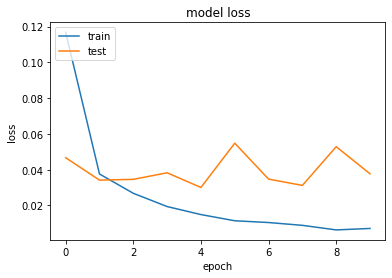

In [36]:

# summarize history for accuracy
pyplot.plot(history3.history['accuracy'])
pyplot.plot(history3.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history3.history['loss'])
pyplot.plot(history3.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

In [37]:
# LARQ FP MODEL w/o Batch Norm. The results should be similar to Experiment 1.
model3b = get_larq_fp(input_shape, use_bn = False)
adam = tkeras.optimizers.Adam(lr = 0.001)
model3b.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history3b = model3b.fit(train_iterator, validation_data = test_iterator, steps_per_epoch=len(train_iterator), epochs=10)

Epoch 1/10
938/938 [==============================] - 19s 21ms/step - loss: 0.1717 - accuracy: 0.9474 - val_loss: 0.0555 - val_accuracy: 0.9830
Epoch 2/10
938/938 [==============================] - 20s 21ms/step - loss: 0.0505 - accuracy: 0.9847 - val_loss: 0.0370 - val_accuracy: 0.9872
Epoch 3/10
938/938 [==============================] - 20s 21ms/step - loss: 0.0361 - accuracy: 0.9890 - val_loss: 0.0309 - val_accuracy: 0.9888
Epoch 4/10
938/938 [==============================] - 20s 21ms/step - loss: 0.0278 - accuracy: 0.9908 - val_loss: 0.0354 - val_accuracy: 0.9890
Epoch 5/10
938/938 [==============================] - 21s 22ms/step - loss: 0.0210 - accuracy: 0.9937 - val_loss: 0.0298 - val_accuracy: 0.9893
Epoch 6/10
938/938 [==============================] - 21s 23ms/step - loss: 0.0177 - accuracy: 0.9941 - val_loss: 0.0318 - val_accuracy: 0.9895
Epoch 7/10
938/938 [==============================] - 21s 23ms/step - loss: 0.0140 - accuracy: 0.9955 - val_loss: 0.0339 - val_accuracy:

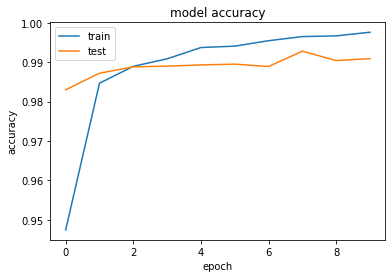

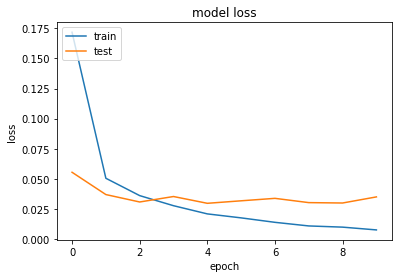

In [38]:
# summarize history for accuracy
pyplot.plot(history3b.history['accuracy'])
pyplot.plot(history3b.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history3b.history['loss'])
pyplot.plot(history3b.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
quant_conv2d_20 (QuantConv2D (None, 26, 26, 32)        288       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 13, 13, 32)        128       
_________________________________________________________________
quant_conv2d_21 (QuantConv2D (None, 11, 11, 64)        18432     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1600)            

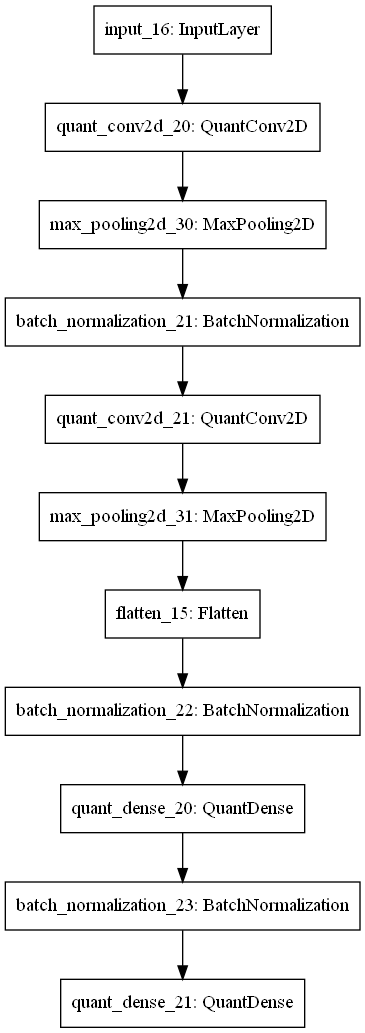

In [58]:
################
# EXPERIMENT 4 #
################

# Binary Model
model4 = binary_model(input_shape, use_bn = True)
adam = tf.keras.optimizers.Adam(lr = 0.001)
model4.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
# Let's have a look to the binary model structure
model4.summary()
tf.keras.utils.plot_model(
    model4,
    to_file="plots/plots.exp4_model.png"
)

In [63]:
# LARQ FP MODEL with BN on MNIST
history4 = model4.fit(train_iterator, validation_data = test_iterator, steps_per_epoch=len(train_iterator), epochs=100)

Epoch 1/100
938/938 [==============================] - 27s 29ms/step - loss: 0.1745 - accuracy: 0.9720 - val_loss: 0.1862 - val_accuracy: 0.9718
Epoch 2/100
938/938 [==============================] - 27s 29ms/step - loss: 0.1652 - accuracy: 0.9734 - val_loss: 0.2646 - val_accuracy: 0.9620
Epoch 3/100
938/938 [==============================] - 27s 29ms/step - loss: 0.1642 - accuracy: 0.9733 - val_loss: 0.1750 - val_accuracy: 0.9708
Epoch 4/100
938/938 [==============================] - 27s 29ms/step - loss: 0.1615 - accuracy: 0.9737 - val_loss: 0.1701 - val_accuracy: 0.9754
Epoch 5/100
938/938 [==============================] - 28s 30ms/step - loss: 0.1540 - accuracy: 0.9752 - val_loss: 0.3875 - val_accuracy: 0.9447
Epoch 6/100
938/938 [==============================] - 27s 29ms/step - loss: 0.1652 - accuracy: 0.9744 - val_loss: 0.3149 - val_accuracy: 0.9524
Epoch 7/100
938/938 [==============================] - 27s 29ms/step - loss: 0.1443 - accuracy: 0.9761 - val_loss: 0.1580 - val_ac

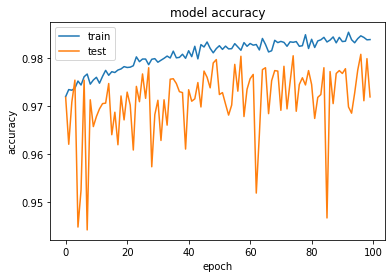

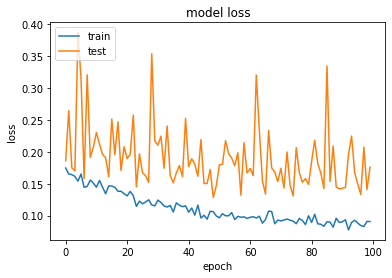

In [64]:
# summarize history for accuracy
pyplot.plot(history4.history['accuracy'])
pyplot.plot(history4.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history4.history['loss'])
pyplot.plot(history4.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

In [51]:
################
# EXPERIMENT 5 #
################

# Binary Model training w/o BatchNorm
model5 = binary_model(input_shape, use_bn = False)
adam = tf.keras.optimizers.Adam(lr = 0.001)
model5.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history5 = model5.fit(train_iterator, validation_data = test_iterator, steps_per_epoch=len(train_iterator), epochs=10)

Epoch 1/10
938/938 [==============================] - 21s 23ms/step - loss: 2.6516 - accuracy: 0.1014 - val_loss: 2.3024 - val_accuracy: 0.0980
Epoch 2/10
938/938 [==============================] - 20s 22ms/step - loss: 2.4926 - accuracy: 0.0985 - val_loss: 2.4070 - val_accuracy: 0.0980
Epoch 3/10
938/938 [==============================] - 20s 22ms/step - loss: 2.4869 - accuracy: 0.0987 - val_loss: 2.4070 - val_accuracy: 0.0980
Epoch 4/10
938/938 [==============================] - 20s 22ms/step - loss: 2.4965 - accuracy: 0.0998 - val_loss: 2.3026 - val_accuracy: 0.0980
Epoch 5/10
938/938 [==============================] - 20s 21ms/step - loss: 2.5598 - accuracy: 0.0993 - val_loss: 2.7316 - val_accuracy: 0.1028
Epoch 6/10
938/938 [==============================] - 20s 21ms/step - loss: 2.6059 - accuracy: 0.1016 - val_loss: 2.6018 - val_accuracy: 0.0974
Epoch 7/10
938/938 [==============================] - 20s 22ms/step - loss: 2.6823 - accuracy: 0.1008 - val_loss: 2.4070 - val_accuracy:

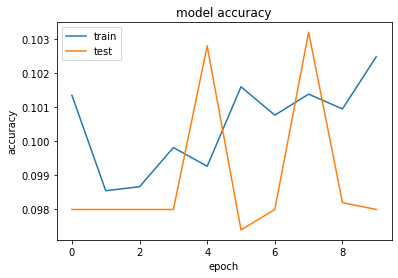

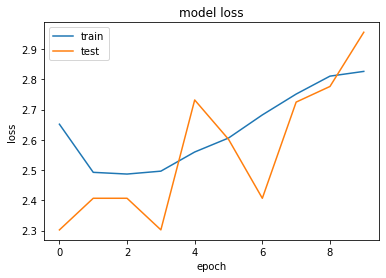

In [52]:
# summarize history for accuracy
pyplot.plot(history5.history['accuracy'])
pyplot.plot(history5.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history5.history['loss'])
pyplot.plot(history5.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

In [61]:
################
# EXPERIMENT 6 #
################

# Binary Model training w/o BatchNorm and BIAS
model6 = binary_model(input_shape, use_bn = False, use_bias = True)
adam = tf.keras.optimizers.Adam(lr = 0.001)
model6.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history6 = model6.fit(train_iterator, validation_data = test_iterator, steps_per_epoch=len(train_iterator), epochs=100)

Epoch 1/100
938/938 [==============================] - 22s 23ms/step - loss: 2.9314 - accuracy: 0.2542 - val_loss: 2.8828 - val_accuracy: 0.2084
Epoch 2/100
938/938 [==============================] - 21s 23ms/step - loss: 2.2049 - accuracy: 0.3808 - val_loss: 1.8322 - val_accuracy: 0.4681
Epoch 3/100
938/938 [==============================] - 20s 21ms/step - loss: 1.7844 - accuracy: 0.5291 - val_loss: 1.4681 - val_accuracy: 0.5963
Epoch 4/100
938/938 [==============================] - 20s 22ms/step - loss: 1.7365 - accuracy: 0.5898 - val_loss: 1.5589 - val_accuracy: 0.6120
Epoch 5/100
938/938 [==============================] - 20s 22ms/step - loss: 1.6523 - accuracy: 0.6253 - val_loss: 1.2703 - val_accuracy: 0.7283
Epoch 6/100
938/938 [==============================] - 20s 22ms/step - loss: 1.5642 - accuracy: 0.6705 - val_loss: 1.2287 - val_accuracy: 0.7202
Epoch 7/100
938/938 [==============================] - 20s 21ms/step - loss: 1.5176 - accuracy: 0.7046 - val_loss: 1.2878 - val_ac

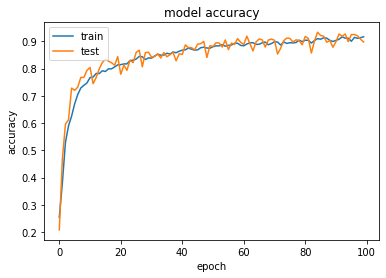

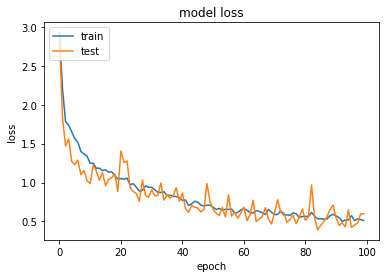

In [62]:
# summarize history for accuracy
pyplot.plot(history6.history['accuracy'])
pyplot.plot(history6.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()
# summarize history for loss
pyplot.plot(history6.history['loss'])
pyplot.plot(history6.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()